In [24]:
%matplotlib inline 

from scipy import stats
from pylab import*
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn
import pandas as pd
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/data/scripts")

import generate_db as gdb
from importlib import reload  

reload(gdb)
gdb.generate_db()

In this project we are trying to identify whether there is any correlation/directional relationship between number of museum visitors and population of cities where those museums are located. For this purpose we created a dataset based on top visited museums from Wikipedia https://en.wikipedia.org/wiki/List_of_most-visited_museums and population data from  https://simplemaps.com/data/world-cities. Data about population density is taken from Google/Wikipedia. 

Lets review the database we created first.

In [25]:
museums = pd.read_csv("../data/db/top_museums.csv", sep='\t')
museums.head()


,rank,name,location,visitors,population,density,id
0,1,Louvre,"Paris, France",8900000,11060000,20000,93912381
1,2,Vatican Museums,"Vatican City, Vatican City",5080866,825,1559,17773258
2,3,Natural History Museum,"London, United Kingdom",4654608,11262000,14500,45260927
3,4,National Museum of Natural History,"Washington, D.C., United States",4400000,4810669,11535,2603950
4,5,British Museum,"London, United Kingdom",4097253,11262000,14500,93233156


Now let's review the behavior/distribution of visitors data, population and density.

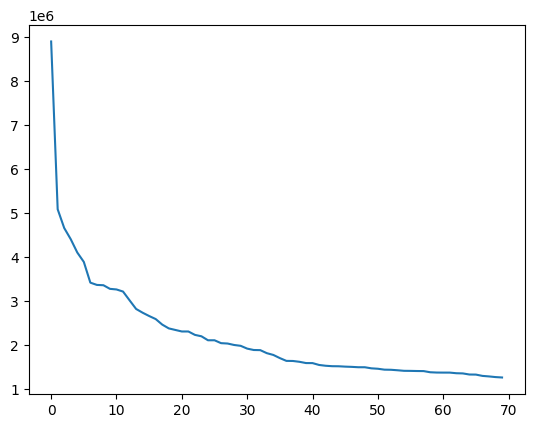

In [26]:
plt.plot(museums.visitors)

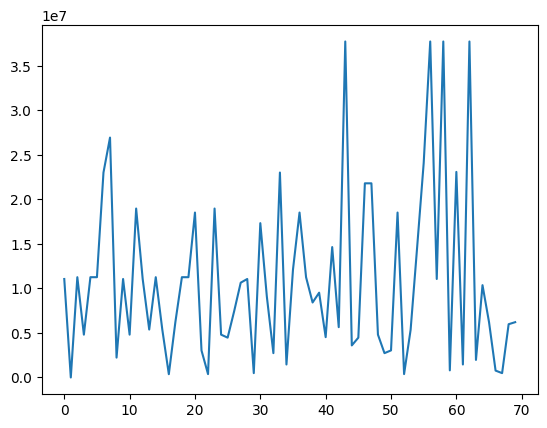

In [27]:
plt.plot(museums.population)

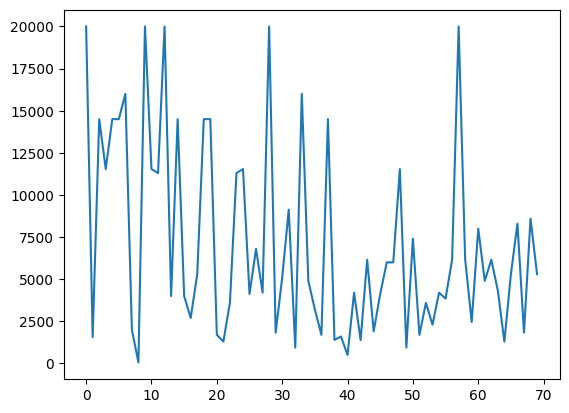

In [28]:
plt.plot(museums.density)

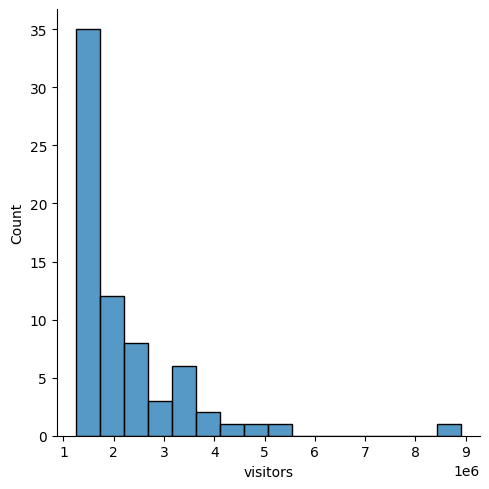

In [29]:
sbn.displot(museums.visitors)

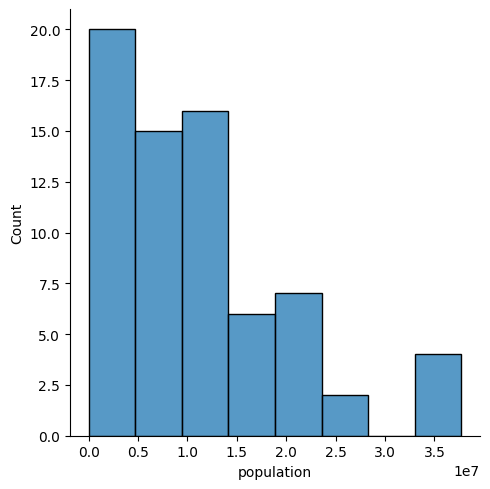

In [30]:
sbn.displot(museums.population)

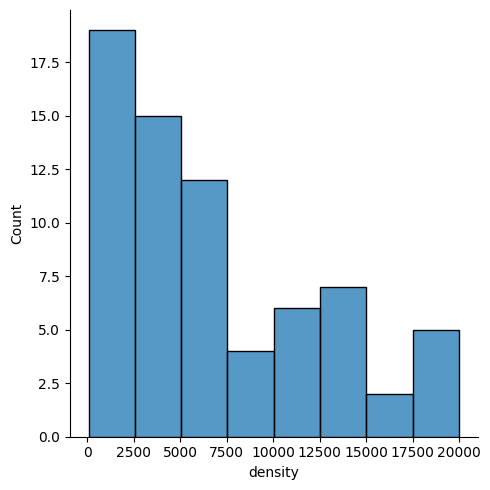

In [31]:
sbn.displot(museums.density)

Typically when we are talking about correlation we are talking about linear correlation. If there is such linear relationship (either positive or negative) it can be typically visible on a scatter plot.

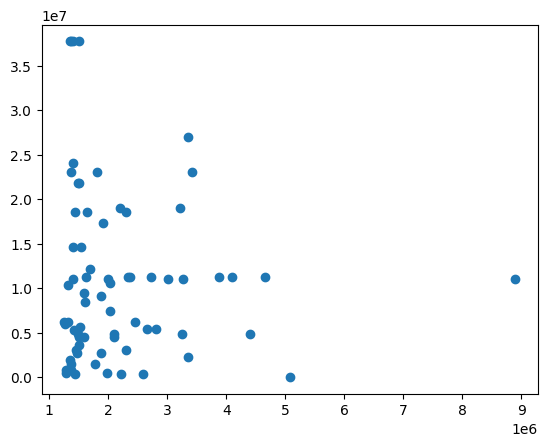

In [32]:
scatter(museums.visitors, museums.population)

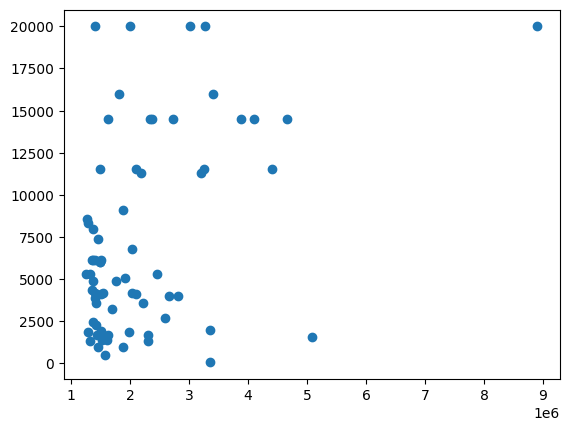

In [33]:
scatter(museums.visitors, museums.density)

In [34]:
#sbn.jointplot(x="visitors", y="population", data=museums, alpha=0.2)

As we can see on the first plot, there is no visible linear relationship between number of visitors and cities population, unlike second plot where we can see at least some resemblance of positive directionality.

Let's see if we can get some numerical confirmation of what we are seeing. Let's calculate two coefficients: 
1. Pearson correlation coefficient which is typically used if there is evidence that data has some linear relationship (and typically normal distributed which is not our case either) and known to be sensitive to outliers
2. Spearman correlation coefficient which seems to be better fitting to our case since it doesn't assume linear relationship, doesn't assume any distribution and more robust to outliers, but more importantly it measures monotonic or ordinal relationship between two features (ranking)

In [35]:
stats.pearsonr(museums.visitors, museums["population"])

PearsonRResult(statistic=-0.06938601570819891, pvalue=0.5681617339202076)

In [36]:
stats.spearmanr(museums.visitors, museums["population"])

SignificanceResult(statistic=0.03772496264421489, pvalue=0.7565176530807314)

As we can see both coefficients are near 0 => no correlation between number of visitors and population of cities. Let's also see what line could be predicted with linear regression in this case for sake of experiment.  

In [37]:
slope, intercept, r_value, p_value, stderr = stats.linregress(museums.visitors, museums.population) 

r_value**2, p_value

(0.004814419175858422, 0.5681617339202064)

Our R-squared value shows a really bad model fit (very low) and our p-value shows low significance (very high). Now lets plot the line that we predicted and how it fits original data.

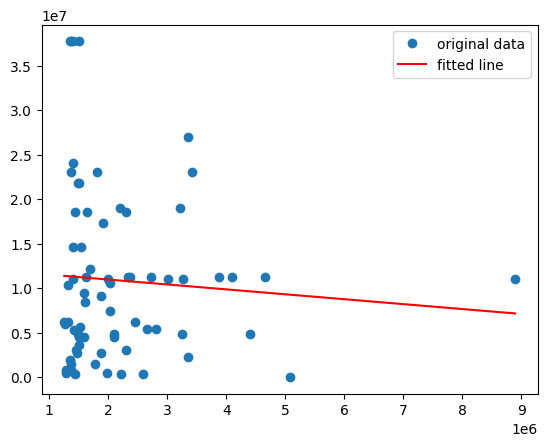

In [38]:
plt.plot(museums.visitors, museums["population"], 'o', label='original data')
plt.plot(museums.visitors, intercept + slope*museums.visitors, 'r', label='fitted line')
plt.legend()
plt.show()

Now let's see what results we get if we use cities population density instead.

In [39]:
stats.pearsonr(museums.visitors, museums["density"])

PearsonRResult(statistic=0.42752688839088654, pvalue=0.00022299431187082703)

In [40]:
stats.spearmanr(museums.visitors, museums["density"])

SignificanceResult(statistic=0.23702405799932105, pvalue=0.04819674293221634)

As we can see both coefficents show there is some moderate positive correlation and since p-value < 0,05 we can consider these results significant. Now let's see what line we can fit to this data. 

In [41]:
slope, intercept, r_value, p_value, stderr = stats.linregress(museums.visitors, museums["density"]) 

r_value, r_value**2, p_value

(0.42752688839088643, 0.18277924029719347, 0.00022299431187082743)

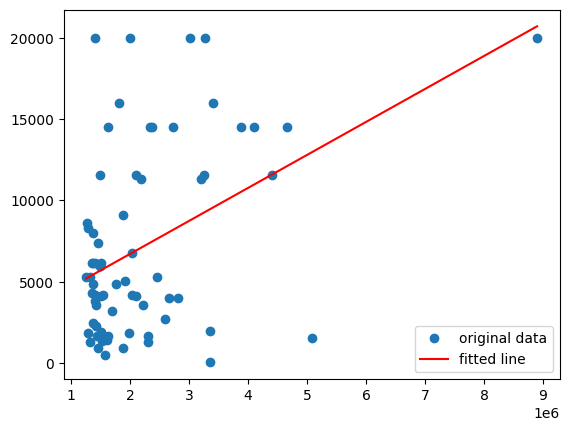

In [42]:
plt.plot(museums.visitors, museums["density"], 'o', label='original data')
plt.plot(museums.visitors, intercept + slope*museums.visitors, 'r', label='fitted line')
plt.legend()
plt.show()

So this time linear regression predicted much better fitting line (which was also predictable from the scatter plot for density). Unfortunately scatterplots containing even modest numbers of data points often look like a blur, so much harder to see confirmation of monotonic relationship. 
To visualize the signal summarized in a dependence metric like a Spearman correlation let's create ranked buckets and average both features and see if can see monotonicity on scatterplot better.

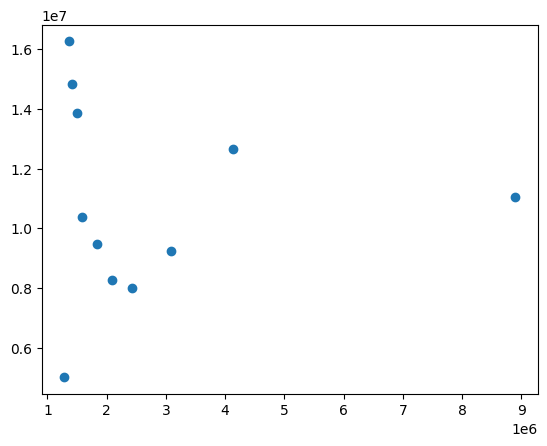

In [43]:
def bucketize(lst, n):
    res=[]
    avg=[]
    b_size=int(len(lst)/n)
    
    for i in range(len(lst)):
      avg.append(lst[i])
      if i%b_size==0:
        res.append(sum(avg)/len(avg))
        avg=[] 
   
    if len(avg)>0:
       res.append(sum(avg)/len(avg))
    return res
    
bv=bucketize(list(museums.visitors), 10)
bd=bucketize(list(museums.density), 10)
bp=bucketize(list(museums.population), 10)

scatter(bv, bp)

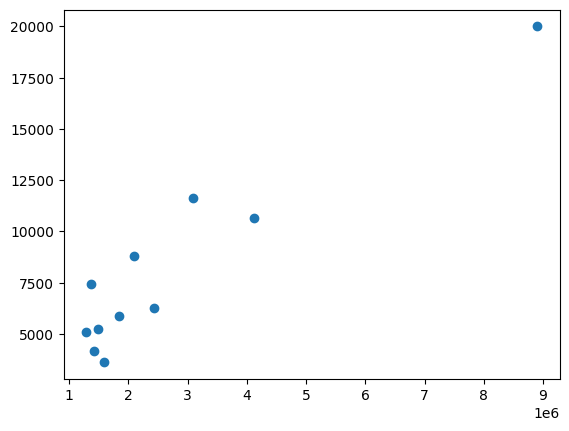

In [44]:
scatter(bv, bd)

We can clearly see no monotonicity in the first case (population), but we can see averaged data clearly is growing monotonously in the second case (density). Let's also fit a predicted line to our averaged data for population density.

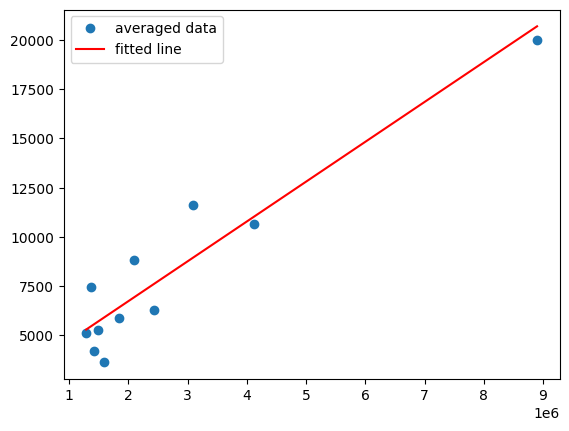

In [45]:
plt.plot(bv, bd, 'o', label='averaged data')
plt.plot(bv, intercept + slope*np.array(bv), 'r', label='fitted line')
plt.legend()
plt.show()

Conclusion: even though it may seem there may be correlation between cities population and museums visitors this is not the case based on the data we got.
But there are definitely some positive linear and monotonic correlations between number of visitors in museums and population density. 